In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import copy
import gc
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple, defaultdict
from itertools import count
import itertools

import cProfile
from tqdm import tqdm
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
import gym
N_ROWS, N_COLS, N_WIN = 3, 3, 3
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, clone=None):
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

## Часть первая: крестики-нолики при помощи Q-обучения

In [6]:
def avail_actions(s):
    string_array = np.array(list(s))
    return np.where(string_array == '1')[0]

def not_avail_actions(s):
    string_array = np.array(list(s))
    return np.where(string_array != '1')[0]

def play_game(env, Q, print_board=False, player1_random=False, player2_random=False):
    env.reset()
    s, empty_spaces, turn = env.getState()
    done = False
    result = [0, 0]
    player = 1
    while not done:
        
        if player == 1 and player1_random or player == -1 and player2_random:
            action = random.choice(avail_actions(s))
        else:
            action = np.argmax(Q[s])
        action_tuple = env.action_from_int(action)
        (s, empty_spaces, turn), reward, done, _ = env.step(action_tuple)
        if print_board:
            env.printBoard()
        player = player * -1
                    
    if reward == 1:
        return (1, 0)
    elif reward == -1:
        return (0, 1)
    else:
        return (0, 0)

def evaluate(env, Q, n=1000, disable_tqdm=False, player1_random=False, player2_random=False):
    rewards1 = []
    rewards2 = []
    for _ in tqdm(range(n), disable=disable_tqdm):
        reward1, reward2 = play_game(
            env, 
            Q, 
            print_board=False, 
            player1_random=player1_random, 
            player2_random=player2_random
        )
        rewards1.append(reward1)
        rewards2.append(reward2)
    r1 = np.mean(rewards1)
    r2 = np.mean(rewards2)
    no_winner = 1 - r1 - r2
    return r1, r2, no_winner

def get_pi_by_Q(Q):
    pi = {k: np.argmax(v) for k, v in Q.items()}
    return defaultdict(int, pi)

class Agent:
    def __init__(self, alpha, gamma, s=None, a=None):
        self.s = s
        self.a = a
        self.alpha = alpha
        self.gamma = gamma
        
    def update_Q(self, Q, state, action, reward):
#         if self.a is not None:
        Q[self.s][self.a] = Q[self.s][self.a] + self.alpha * (reward + self.gamma * np.max(Q[state]) - Q[self.s][self.a])
        self.s = state
        self.a = action
        
def Q_learning_episode(env, Q, A, alpha=0.05, epsilon=0.1, gamma=1):
    env.reset()
    s, empty_spaces, turn = env.getState()    
    agents = (
        Agent(alpha=alpha, gamma=gamma), 
        Agent(alpha=alpha, gamma=gamma)
    )
    done = False
    agent_idx = 0
    
    while not done:
        Q[s][not_avail_actions(s)] = -9999
        a = np.argmax(Q[s]) if random.random() < (1 - epsilon) else random.choice(avail_actions(s))
        agent = agents[agent_idx]
        agent.update_Q(Q, s, a, 0)
        agent_idx = 1 - agent_idx 
        (s, empty_spaces, turn), r , done, _ = env.step(env.action_from_int(a))    

    if r == -10:
        agent.update_Q(Q, s, a, r)
    else:
        agents[0].update_Q(Q, s, a, r) 
        agents[1].update_Q(Q, s, a, -r) 
        
    return Q

def Q_learning(env, Q, A, episodes=100000, alpha=0.05, evaluate_every=100, epsilon=0.3, gamma=1, disable_tqdm=False):
    hist_p1 = []
    hist_p2 = []
    iters = []

    for i in tqdm(range(episodes), disable=disable_tqdm):
        Q = Q_learning_episode(env=env, Q=Q, A=A, alpha=alpha, epsilon=epsilon, gamma=gamma)
        if i % evaluate_every == 0:
            res_p1 = evaluate(env, Q, n=100, disable_tqdm=True, player1_random=False, player2_random=True)[0]
            res_p2 = evaluate(env, Q, n=100, disable_tqdm=True, player1_random=True, player2_random=False)[1]
            hist_p1.append(res_p1)
            hist_p2.append(res_p2)
            iters.append(i)
            
    return Q, (hist_p1, hist_p2), iters

Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [15]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
env.reset()
game_hash, empty_spaces, _ = env.getState()
A = tuple(range(len(empty_spaces)))
Q = defaultdict(lambda: np.zeros(len(A)))

In [16]:
Q, (q_hist_p1, q_hist_p2), iters = Q_learning(env, Q, A, episodes=50000, alpha=0.01, epsilon=0.7)

100%|██████████| 50000/50000 [01:44<00:00, 480.36it/s]


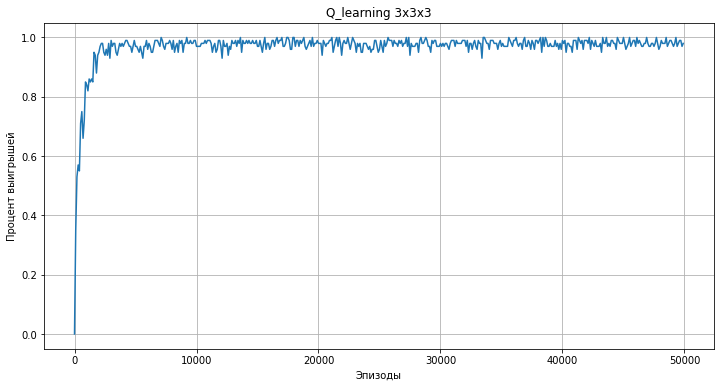

In [18]:
plt.figure(figsize=(12, 6))
plt.title('Q_learning 3x3x3')
plt.xlabel('Эпизоды')
plt.ylabel('Процент выигрышей')
plt.grid(True)
plt.plot(iters, q_hist_p1);

Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

In [13]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
env.reset()
game_hash, empty_spaces, _ = env.getState()
A = tuple(range(len(empty_spaces)))
Q = defaultdict(lambda: np.zeros(len(A)))
Q, (hist_p1, hist_p2), iters = Q_learning(env, Q, A, episodes=1000000, alpha=0.05, epsilon=0.7, evaluate_every=1000)

100%|██████████| 1000000/1000000 [40:57<00:00, 406.87it/s]


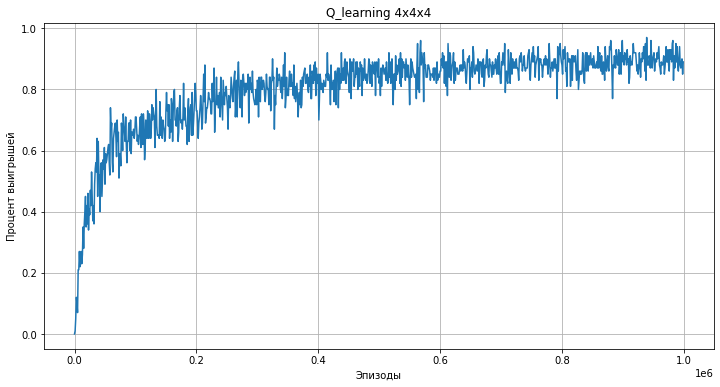

In [14]:
plt.figure(figsize=(12, 6))
plt.title('Q_learning 4x4x4')
plt.xlabel('Эпизоды')
plt.ylabel('Процент выигрышей')
plt.grid(True)
plt.plot(iters, hist_p1);

## Часть вторая: добавим нейронных сетей

In [19]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

class Player:
    def __init__(self, memory_capacity=10000):
        self.state = None
        self.action = None
        self.reward = None
        self.next_state = None
        self.memory = ReplayMemory(capacity=memory_capacity)
    
    def add_exp(self, next_state, action, reward):
        
        next_state = state_to_layers(next_state)
        if self.state is not None:
            self.memory.store((self.state, next_state, self.action, reward))
        self.state = next_state
        self.action = action
        
    def new_game(self):
        self.state = None
        self.action = None        

        
def state_to_layers(state):
    return np.array([
        (state == 1).astype(float), 
        (state == -1).astype(float), 
        (state == 0).astype(float)
    ])
        
def get_action_from_model(model, state):
    model.eval()
    state = state_to_layers(state)
    state = torch.FloatTensor([state])
    action = model(state).detach().max(1)[1][0].item()
    return action

def avail_actions(s):
    string_array = np.array(list(s))
    return np.where(string_array == '1')[0]
    
def get_action(model, state, game_hash, epsilon):
    if random.random() < (1 - epsilon):
        action = get_action_from_model(model, state)
    else:
        action = random.choice(avail_actions(game_hash))
    return action
        
def play_game_model(env, model, print_board=False, player1_random=False, player2_random=False):
    env.reset()
    game_hash, empty_spaces, turn = env.getState()
    state = env.board
    done = False
    result = [0, 0]
    player = 1
    while not done:
        
        if player == 1 and player1_random or player == -1 and player2_random:
            action = random.choice(avail_actions(game_hash))
        else:
            action =  get_action_from_model(model, state)
        action_tuple = env.action_from_int(action)
        (game_hash, empty_spaces, turn), reward, done, _ = env.step(action_tuple)
        state = env.board

        player = player * -1
                    
    if reward == 1:
        return (1, 0)
    elif reward == -1:
        return (0, 1)
    else:
        return (0, 0)
        
def evaluate_model(env, model, n=1000, disable_tqdm=False, player1_random=False, player2_random=False):
    model.eval()
    rewards1 = []
    rewards2 = []
    for _ in tqdm(range(n), disable=disable_tqdm):
        reward1, reward2 = play_game_model(
            env, 
            model, 
            print_board=False, 
            player1_random=player1_random, 
            player2_random=player2_random
        )
        rewards1.append(reward1)
        rewards2.append(reward2)
    r1 = np.mean(rewards1)
    r2 = np.mean(rewards2)
    no_winner = 1 - r1 - r2
    return r1, r2, no_winner

def train_batch(model, optimizer, criterion, replay_memory, batch_size=128, gamma=1):
    
    if len(replay_memory) < batch_size:
        return
    
    
    states, next_states, actions, rewards = list(zip(*replay_memory.sample(batch_size)))
    
    
    batch_state = torch.FloatTensor(states)
    batch_next_state = torch.FloatTensor(next_states)
    batch_actions = torch.LongTensor(actions)
    batch_reward = torch.FloatTensor(rewards) / 11.
    
    model.train()
    Q = model(batch_state).gather(1, batch_actions.view(-1, 1)).flatten()
    Qmax = model(batch_next_state).detach().max(dim=1)[0]
    Qnext = batch_reward + (gamma * Qmax)
    
    loss = criterion(Q, Qnext)

    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()


def play_episode(env, model1, model2, epsilon, player1, player2):
    env.reset()
    model1.eval()
    model2.eval()
    game_hash, empty_spaces, turn = env.getState()
    state = env.board.copy()
    done = False
    player1.new_game()
    player2.new_game()
    players = (player1, player2)
    models = (model1, model2)
    player_idx = 0
    
    while not done:
        player = players[player_idx]
        model = models[player_idx]
        action = get_action(model, state, game_hash, epsilon)
        player.add_exp(state, action, 0)
        player_idx = 1 - player_idx
        (game_hash, empty_spaces, turn), reward , done, _ = env.step(env.action_from_int(action))
        state = env.board.copy()
        
    if reward == -10:
        player.add_exp(state, action, reward)
    else:
        players[0].add_exp(state, action, reward)
        players[1].add_exp(state, action, -reward)
        

def run_learning(env, model1_tuple, model2_tuple, criterion, episodes=10000, eps_init=0.5, batch_size=64, gamma=1, model_name='dqn'):
    p1, p2 = Player(), Player()
    model1, optimizer1, scheduler1 = model1_tuple
    model2, optimizer2, scheduler2 = model2_tuple
    
    loss_cache_p1 = []
    loss_cache_p2 = []
    hist_p1 = []
    hist_p2 = []
    iters = []
    loss_hist_p1 = []
    loss_hist_p2 = []
    best_result_p1 = 0
    best_result_p2 = 0
    pbar = tqdm(range(episodes))
    
    eps_final = 0.05
    eps_decay = int(episodes / 2)
    
    for i in pbar:
        eps_threshold = eps_init
        for _ in range(1):
            play_episode(env, model1, model2, eps_threshold, p1, p2)
        
        loss1 = train_batch(model1, optimizer1, criterion, p1.memory, batch_size=batch_size, gamma=gamma)
        loss2 = train_batch(model2, optimizer2, criterion, p2.memory, batch_size=batch_size, gamma=gamma)
        if loss1 is not None:
            loss_cache_p1.append(loss1)
        if loss2 is not None:
            loss_cache_p2.append(loss2)
        
        if (i + 1) % 100 == 0:
            result_p1, _, _ = evaluate_model(env, model1, n=200, player1_random=False, player2_random=True, disable_tqdm=True)
            _, result_p2, _ = evaluate_model(env, model2, n=200, player1_random=True, player2_random=False, disable_tqdm=True)
            
            iters.append(i)
            hist_p1.append(result_p1)
            hist_p2.append(result_p2)
            
            mean_loss_p1 = np.mean(loss_cache_p1) if loss_cache_p1 else 0
            loss_hist_p1.append(mean_loss_p1)
            
            mean_loss_p2 = np.mean(loss_cache_p2) if loss_cache_p2 else 0
            loss_hist_p2.append(mean_loss_p2)
            
            loss_cache_p1 = []
            loss_cache_p2 = []
            
            total_result = result_p1 + result_p2
            if scheduler1 is not None:
                scheduler1.step(mean_loss_p1)
            if scheduler2 is not None:
                scheduler2.step(mean_loss_p2)
            
            pbar.set_postfix({
                'l1': mean_loss_p1, 
                'l2': mean_loss_p2, 
                'p1': result_p1, 
                'p2': result_p2, 
                'eps': eps_threshold,
            })

            if best_result_p1 < result_p1:
                torch.save(model1.state_dict(), f'best_{model_name}_p1.pth')
            if best_result_p2 < result_p2:
                torch.save(model2.state_dict(), f'best_{model_name}_p2.pth')
                
    return (hist_p1, hist_p2), (loss_hist_p1, loss_hist_p2), iters

Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

In [20]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
class DQN_3x3(nn.Module):
    def __init__(self, hidden_size=512):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=hidden_size, kernel_size=(3, 3))
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 9)       
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = x.squeeze(-1).squeeze(-1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x
model = DQN_3x3().eval()
LR = 1e-6
WEIGHT_DECAY = 1e-9
HIDDEN_SIZE = 512
criterion = F.l1_loss

model1 = DQN_3x3(hidden_size=HIDDEN_SIZE)
optimizer1 = optim.Adam(model1.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

model2 = DQN_3x3(hidden_size=HIDDEN_SIZE)
optimizer2 = optim.Adam(model2.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [21]:
(nn_hist_p1, nn_hist_p2), (loss_hist_p1, loss_hist_p2), iters = run_learning(
    env, 
    (model1, optimizer1, None), 
    (model2, optimizer2, None), 
    criterion,
    episodes=20000, 
    eps_init=0.5,
    batch_size=256,
    gamma=0.9
)

100%|██████████| 20000/20000 [23:38<00:00, 14.10it/s, l1=0.0323, l2=0.0417, p1=0.96, p2=0.85, eps=0.5]


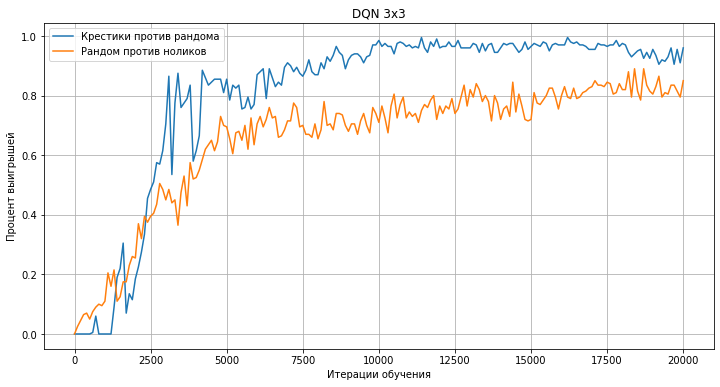

In [22]:
plt.figure(figsize=(12, 6))
plt.title('DQN 3x3')
plt.xlabel('Итерации обучения')
plt.ylabel('Процент выигрышей')
plt.grid(True)
plt.plot([0] + iters, [0] + nn_hist_p1, label='Крестики против рандома')
plt.plot([0] + iters, [0] + nn_hist_p2, label='Рандом против ноликов')
plt.legend();

Реализуйте Double DQN и/или Dueling DQN

In [23]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
class DuelingDQN_3x3(nn.Module):
    def __init__(self, hidden_size=256):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=hidden_size, kernel_size=(3, 3))
    
        self.V = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )
        
        self.A = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 9),
        )
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = x.squeeze(-1).squeeze(-1)
        A = self.A(x)
        V = self.V(x)
        Q = V + (A - A.mean(dim=1, keepdim=True).expand(x.size(0), 9))
        return Q
model = DuelingDQN_3x3().eval()
LR = 1e-6
WEIGHT_DECAY = 1e-7
HIDDEN_SIZE = 512
criterion = F.l1_loss

model1 = DuelingDQN_3x3(hidden_size=HIDDEN_SIZE)
optimizer1 = optim.Adam(model1.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

model2 = DuelingDQN_3x3(hidden_size=HIDDEN_SIZE)
optimizer2 = optim.Adam(model2.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [24]:
(ddqn_hist_p1, ddqn_hist_p2), (loss_hist_p1, loss_hist_p2), iters = run_learning(
    env, 
    (model1, optimizer1, None), 
    (model2, optimizer2, None), 
    criterion,
    episodes=20000, 
    eps_init=0.5,
    batch_size=128,
    model_name='dueling_dqn',
    gamma=0.9
)

100%|██████████| 20000/20000 [21:45<00:00, 15.32it/s, l1=0.0416, l2=0.0801, p1=0.81, p2=0.685, eps=0.5]


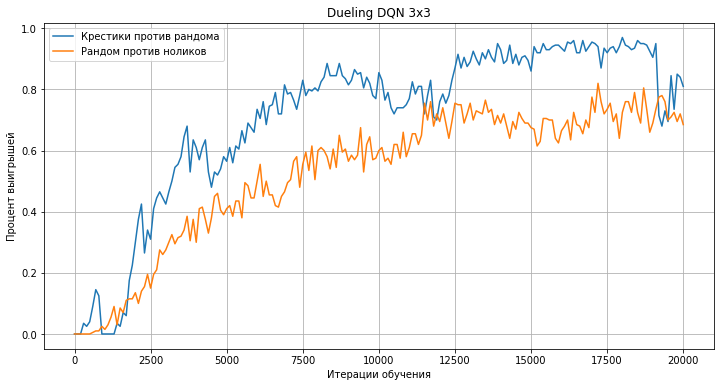

In [25]:
plt.figure(figsize=(12, 6))
plt.title('Dueling DQN 3x3')
plt.xlabel('Итерации обучения')
plt.ylabel('Процент выигрышей')
plt.grid(True)
plt.plot([0] + iters, [0] + ddqn_hist_p1, label='Крестики против рандома')
plt.plot([0] + iters, [0] + ddqn_hist_p2, label='Рандом против ноликов')
plt.legend();

## Часть третья: расширим и углубим поиск

Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов.


Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).

In [27]:
def random_policy(A, state):
    return random.choice(A)

def rollout(env: TicTacToe, policy):
    env = copy.deepcopy(env)
    state, empty_spaces, turn = env.getState()
    player = -turn
    done = False
    turn_idx = 0
    while not done:
        A = avail_actions(state)
        action = policy(A, state)
        action_tuple = env.action_from_int(action)
        (state, empty_spaces, turn), reward, done, _ = env.step(action_tuple)
        turn_idx = 1 - turn_idx
        
    return reward * player

def get_rollouts_action(env: TicTacToe, policy, n_iters=20):
    env_current = copy.deepcopy(env)
    state, empty_spaces, turn = env_current.getState()
    player = turn
    A = avail_actions(state)
    results = dict()
    for action in A:
        env_current = copy.deepcopy(env)
        action_tuple = env.action_from_int(action)
        (state, empty_spaces, turn), reward, done, _ = env_current.step(action_tuple)
        if not done:
            results[action] = np.mean([rollout(env_current, policy) for _ in range(n_iters)])
        else:
            results[action] = reward * player
        
    best_action = max(results, key=results.get)
    return best_action
        

def play_with_rollouts(env: TicTacToe, use_rollouts, policies, n_rollouts):
    env.reset()
    state, empty_spaces, turn = env.getState()
    done = False
    turn_idx = 0
    
    while not done:
        A = avail_actions(state)
        
        if use_rollouts[turn_idx]:
            action = get_rollouts_action(env, policies[turn_idx], n_iters=n_rollouts)
        else:
            action = random.choice(A)
            
        action_tuple = env.action_from_int(action)
        (state, empty_spaces, turn), reward, done, _ = env.step(action_tuple)
        turn_idx = 1 - turn_idx
        
    return reward
         
def evaluate_rollouts(env, use_rollouts=(True, False), policies=(random_policy, random_policy), n_games=500, n_rollouts=20):
    wins = defaultdict(int)
    pbar = tqdm(range(n_games))
    for i in pbar:
        reward = play_with_rollouts(env, use_rollouts=use_rollouts, policies=policies, n_rollouts=n_rollouts)
        wins[reward] += 1
        pbar.set_postfix({'X': wins[1] / (i + 1), 'O': wins[-1] / (i + 1), 'nichya': wins[0] / (i + 1)})
    return (
        wins[1] / n_games,
        wins[-1] / n_games,
        wins[0] / n_games,
    )
SIZE = 3
env = TicTacToe(n_rows=SIZE, n_cols=SIZE, n_win=SIZE)
env.reset()
game_hash, empty_spaces, _ = env.getState()
A = tuple(range(len(empty_spaces)))

In [28]:
Q_33 = defaultdict(lambda: np.zeros(len(A)))
Q_33, _, _ = Q_learning(env, Q_33, A, episodes=100000, alpha=0.01, epsilon=0.7, disable_tqdm=False, evaluate_every=1000000)

100%|██████████| 100000/100000 [01:36<00:00, 1033.20it/s]


In [29]:
def get_Q_policy(Q_for_policy):
    def Q_policy(A, state):
        Qsa = {action: Q_for_policy[state][action] for action in A} 
        best_action = max(Qsa, key=Qsa.get)
        return best_action
    return Q_policy

Крестики с rollouts со случайной стратегией

In [30]:
krestiki, noliki, nichya = evaluate_rollouts(
    env, 
    use_rollouts=(True, False), 
    policies=(random_policy, None), 
    n_games=1000, 
    n_rollouts=50,
)
print(f'x: {krestiki:.3f}, o: {noliki:.3f}, ничья: {nichya:.3f}')

100%|██████████| 1000/1000 [08:29<00:00,  1.96it/s, X=0.982, O=0, nichya=0.018]

x: 0.982, o: 0.000, ничья: 0.018


Нолики с rollouts со случайной стратегией

In [31]:
krestiki, noliki, nichya = evaluate_rollouts(
    env, 
    use_rollouts=(False, True), 
    policies=(None, random_policy), 
    n_games=1000, 
    n_rollouts=50,
)
print(f'x: {krestiki:.3f}, o: {noliki:.3f}, ничья: {nichya:.3f}')

100%|██████████| 1000/1000 [06:18<00:00,  2.64it/s, X=0.047, O=0.886, nichya=0.067]

x: 0.047, o: 0.886, ничья: 0.067


Крестики с rollouts с неслучайной стратегией (Q из пункта 1)

In [32]:
krestiki, noliki, nichya = evaluate_rollouts(
    env, 
    use_rollouts=(True, False), 
    policies=(get_Q_policy(Q_33), None), 
    n_games=1000, 
    n_rollouts=50,
)
print(f'x: {krestiki:.3f}, o: {noliki:.3f}, ничья: {nichya:.3f}')

100%|██████████| 1000/1000 [10:10<00:00,  1.64it/s, X=0.99, O=0, nichya=0.01]

x: 0.990, o: 0.000, ничья: 0.010


## Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

In [33]:
class Node:
    def __init__(self, state, action, player, parent=None, is_new=True):
        self.state = state
        self.action = action
        self.parent = parent
        self.player = player
        self.krestiki = 0
        self.noliki = 0
        self.visits = 0
        self.children = []
        self.is_new = is_new
        self.is_terminal = False
        
    def value(self):
        if self.visits == 0:
            return 0
        
        node_val = self.krestiki if self.player == 1 else self.noliki
        return node_val / self.visits
    
    def __repr__(self): 
        return f'X: {self.krestiki}, O: {self.noliki}, V: {self.visits},  P: {self.player}, S: {self.state}, ' \
            f'A: {self.action}, children:{len(self.children)}, is_terminal: {self.is_terminal}'
        
        
class MCTS:
    def __init__(self, env, exploration_const, policy, player):
        self.env = env
        self.size = self.env.n_rows
        
        self.C = exploration_const
        self.policy = policy
        self.player = player
        self.env.reset()
        state, empty_spaces, turn = self.env.getState()
        self.root = Node(state=state, action=None, player=-1, parent=None, is_new=False)
        
#         self.nodes = []
        self.hist = [0]
        self.hist_iters = [0]
        
        
    @staticmethod
    def update_state_with_action(s, action, player):
        action_str = str(player + 1)
        new_hash = s[:action] + action_str + s[action + 1:]
        return new_hash
    
    
    def evalueate_tree(self, random_policy, n_games=5000):
        rewards = []
        for _ in range(n_games):
            node = self.root
            self.env.reset()
            state, empty_spaces, turn = self.env.getState()
            done = False
            turn_idx = 0

            while not done:
                
                if node.children:
                    if random_policy[turn_idx]:
                        child = random.choice(node.children)
                    else:
                        child = max(node.children, key=lambda x: x.value())
                    node = child
                    action = child.action
                else:
                    A = avail_actions(state)
                    action = random.choice(A)
                    
                action_tuple = env.action_from_int(action)
                (state, empty_spaces, turn), reward, done, _ = self.env.step(action_tuple)
                turn_idx = 1 - turn_idx
            rewards.append(reward)
        return rewards.count(1) / n_games, rewards.count(-1) / n_games, rewards.count(0) / n_games
    
    @staticmethod
    def backprop(node, krestiki, noliki):
        while node is not None:
            node.krestiki += krestiki
            node.noliki += noliki
            node.visits += 1
            node = node.parent
            
    def get_child_ucb(self, node):
        ucbs = []
        
        for child in node.children:
            ucb = child.value() + self.C * np.sqrt(np.log(node.visits) / child.visits)
            ucbs.append(ucb)
        ucb_idx = np.argmax(ucbs)
        best_child = node.children[ucb_idx]
        return best_child
    
    def play_game_from_state(self, state, turn):
        self.env.reset()
        board = np.array([int(c) - 1 for c in state]).reshape(self.size, self.size)
        self.env.board = board
        self.env.curTurn = turn
        is_terminal = False
        done = False
        
        if self.env.isTerminal() is not None:
            reward = self.env.isTerminal()
            done = True
            is_terminal = True        
        
        while not done:
            A = avail_actions(state)
            if self.env.curTurn == self.player:
                action = self.policy(A, state)
            else:
                action = random.choice(A)
            action_tuple = self.env.action_from_int(action)
            (state, empty_spaces, turn), reward, done, _ = self.env.step(action_tuple)
            
        
        return reward, is_terminal
            
            
    def rollout(self, node):
        if node.is_terminal:
            krestiki = int(node.krestiki > 0)
            noliki = int(node.noliki > 0)
            return krestiki, noliki, node.is_terminal
        
        
        krestiki = 0
        noliki = 0
        
        turn = node.player * -1
        state = node.state

        reward, is_terminal = self.play_game_from_state(state, turn)

        if reward == 1:
            krestiki += 1
        if reward == -1:
            noliki += 1
        
        return krestiki, noliki, is_terminal
            
    def learning_step(self):
        node = self.root
        
        while True:
            
            if node.is_terminal:
                krestiki, noliki, is_terminal = self.rollout(node)
                node.krestiki += krestiki
                node.noliki += noliki
                node.is_terminal = is_terminal
                node.is_new = False
                self.backprop(node, krestiki, noliki)
                break
                
            possible_actions = set(avail_actions(node.state))
            child_actions = {child.action for child in node.children}
            left_actions = possible_actions - child_actions
            
            if left_actions:
                action = random.choice(list(left_actions))
                new_player = node.player * -1
                new_state = self.update_state_with_action(node.state, action, new_player) # проверить
                
                child = Node(
                    state=new_state,
                    action=action,
                    player=new_player,
                    parent=node,
                )
                
                node.children.append(child)
                
                krestiki, noliki, is_terminal = self.rollout(child)
                child.krestiki += krestiki
                child.noliki += noliki
                child.is_terminal = is_terminal
                child.is_new = False
                self.backprop(child, krestiki, noliki)
                
            else:
                if node.player == -self.player:
                    child = self.get_child_ucb(node)
                else:
                    child = random.choice(node.children)
                
            node = child
            
            

    def run_learning(self, n_iters=1000, eval_every=50):
        pbar = tqdm(range(n_iters))
        for i in pbar:
            self.learning_step()
            if (i + 1) % eval_every == 0:
                self.save_point_history(i, eval_every)
                pbar.set_postfix({
                    'player': self.player,
                    'win raito': self.hist[-1]
                })
            
    def save_point_history(self, num_iter, eval_every):
                
        random_policy_flags = (False, True) if self.player == 1 else (True, False)
        res_p1, res_p2, res_nichya = self.evalueate_tree(random_policy=random_policy_flags, n_games=500)
        
        if self.player == 1:
            self.hist.append(res_p1)
        if self.player == -1:
            self.hist.append(res_p2)
            
        self.hist_iters.append(self.hist_iters[-1] + eval_every)

In [34]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
env.reset()
game_hash, empty_spaces, _ = env.getState()
A = tuple(range(len(empty_spaces)))
mcts_p1 = MCTS(env, exploration_const=1.41, policy=get_Q_policy(Q_33), player=1)
mcts_p1.run_learning(n_iters=20000, eval_every=50)

100%|██████████| 20000/20000 [01:38<00:00, 203.21it/s, player=1, win raito=0.978]


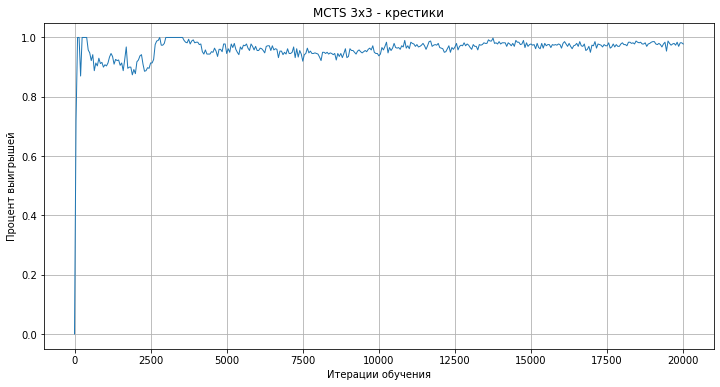

In [35]:
plt.figure(figsize=(12, 6))
plt.title(f'MCTS 4x4 - крестики, C={mcts_p1.C}')
plt.xlabel('Итерации обучения')
plt.ylabel('Процент выигрышей')
plt.grid(True)
plt.plot(mcts_p1.hist_iters, mcts_p1.hist, lw=1);

### MCST 4x4

In [38]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
mcts_p1 = MCTS(env, exploration_const=1.41, policy=random_policy, player=1)
mcts_p1.run_learning(n_iters=1000000, eval_every=5000)

100%|██████████| 1000000/1000000 [46:28<00:00, 358.57it/s, player=1, win raito=0.972]


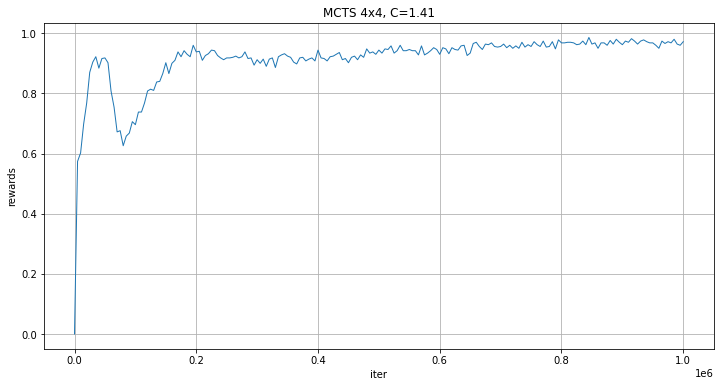

In [41]:
plt.figure(figsize=(12, 6))
plt.title(f'MCTS 4x4, C={mcts_p1.C}')
plt.xlabel('iter')
plt.ylabel('rewards')
plt.grid(True)
plt.plot(mcts_p1.hist_iters, mcts_p1.hist, lw=1);

Выводы:

На поле 3x3 MCST оказался лучше всех и быстрее обучался.

А на поле 4x4 тоже лучше но по Q-learning но не быстрее. По времени они примерно одинаковые 